##  Supervised Learning flow

In [2]:
# Load libraries
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report


In [3]:
# Load datasets
wine_train = pd.read_csv('wine_train.csv')
wine_test  = pd.read_csv('wine_test.csv')


# Display first few rows
print('Wine Train Dataset:')
wine_train.head()

Wine Train Dataset:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,12.08,1.83,2.32,18.5,81.0,1.60,1.50,0.52,1.64,2.40,1.08,2.27,480.0,1
1,13.58,2.58,2.69,24.5,105.0,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750.0,2
2,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0,1
3,11.82,1.72,1.88,19.5,86.0,2.50,1.64,0.37,1.42,2.06,0.94,2.44,415.0,1
4,13.16,3.57,2.15,21.0,102.0,1.50,0.55,0.43,1.30,4.00,0.60,1.68,830.0,2


In [4]:
# Display first few rows
print('Wine Test Dataset:')
wine_test.head()

Wine Test Dataset:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.78,2.76,2.30,22.0,90.0,1.35,0.68,0.41,1.03,9.58,0.70,1.68,615.0,2
1,14.02,1.68,2.21,16.0,96.0,2.65,2.33,0.26,1.98,4.70,1.04,3.59,1035.0,0
2,13.17,5.19,2.32,22.0,93.0,1.74,0.63,0.61,1.55,7.90,0.60,1.48,725.0,2
3,11.03,1.51,2.20,21.5,85.0,2.46,2.17,0.52,2.01,1.90,1.71,2.87,407.0,1
4,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2


 ### Data Cleansing

In [5]:
# Check for null values
wine_train.isna().sum() # there are None

# Try to find outliers using the z_score method
wine_train['z_score'] = stats.zscore(wine_train['alcohol'])
outliers = wine_train[wine_train['z_score'].abs() > 3]
print(outliers) # There are None

# Try to find outliers using the IQR method (split the data in the 25 and 75 precentile)
Q1 = wine_train['alcohol'].quantile(0.25)
Q3 = wine_train['alcohol'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = wine_train[(wine_train['alcohol'] < lower_bound) | (wine_train['alcohol'] > upper_bound)]
print(outliers) # There are None

Empty DataFrame
Columns: [alcohol, malic_acid, ash, alcalinity_of_ash, magnesium, total_phenols, flavanoids, nonflavanoid_phenols, proanthocyanins, color_intensity, hue, od280/od315_of_diluted_wines, proline, target, z_score]
Index: []
Empty DataFrame
Columns: [alcohol, malic_acid, ash, alcalinity_of_ash, magnesium, total_phenols, flavanoids, nonflavanoid_phenols, proanthocyanins, color_intensity, hue, od280/od315_of_diluted_wines, proline, target, z_score]
Index: []



## Exploratory Data Analysis (EDA)

In [6]:
# Summary Statistics for Train 
print('Summary Statistics for Train:')
print(wine_train.describe())

Summary Statistics for Train:
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  142.000000  142.000000  142.000000         142.000000  142.000000   
mean    12.997254    2.297746    2.361690          19.419718   99.943662   
std      0.789931    1.093317    0.283231           3.354815   13.683751   
min     11.410000    0.740000    1.360000          10.600000   78.000000   
25%     12.370000    1.592500    2.222500          17.250000   88.000000   
50%     13.050000    1.865000    2.360000          19.250000   98.000000   
75%     13.637500    3.020000    2.557500          21.375000  108.000000   
max     14.750000    5.650000    3.230000          30.000000  151.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     142.000000  142.000000            142.000000       142.000000   
mean        2.315986    2.063592              0.346690         1.561901   
std         0.639469    1.005302              0.117562      

In [7]:
# target variable distribution matrix
print('\nTarget Variable Distribution:')
print(wine_train['target'].value_counts())


Target Variable Distribution:
target
1    57
0    48
2    37
Name: count, dtype: int64


In [8]:
# Create a correlation matrix
corr_matrix = wine_train.corr()
print('\nCorrelation Matrix:')
print(corr_matrix)


Correlation Matrix:
                               alcohol  malic_acid       ash  \
alcohol                       1.000000    0.125775  0.266255   
malic_acid                    0.125775    1.000000  0.191182   
ash                           0.266255    0.191182  1.000000   
alcalinity_of_ash            -0.324234    0.282662  0.423830   
magnesium                     0.308843    0.020063  0.378546   
total_phenols                 0.271331   -0.322301  0.161905   
flavanoids                    0.247231   -0.388624  0.164921   
nonflavanoid_phenols         -0.088818    0.287977  0.148841   
proanthocyanins               0.137788   -0.185538  0.065193   
color_intensity               0.538669    0.250443  0.270956   
hue                          -0.009125   -0.550526 -0.067239   
od280/od315_of_diluted_wines  0.066571   -0.328693  0.040355   
proline                       0.668455   -0.150744  0.275818   
target                       -0.342386    0.392434 -0.109604   
z_score            

C:\Users\evyatar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x1200 with 0 Axes>

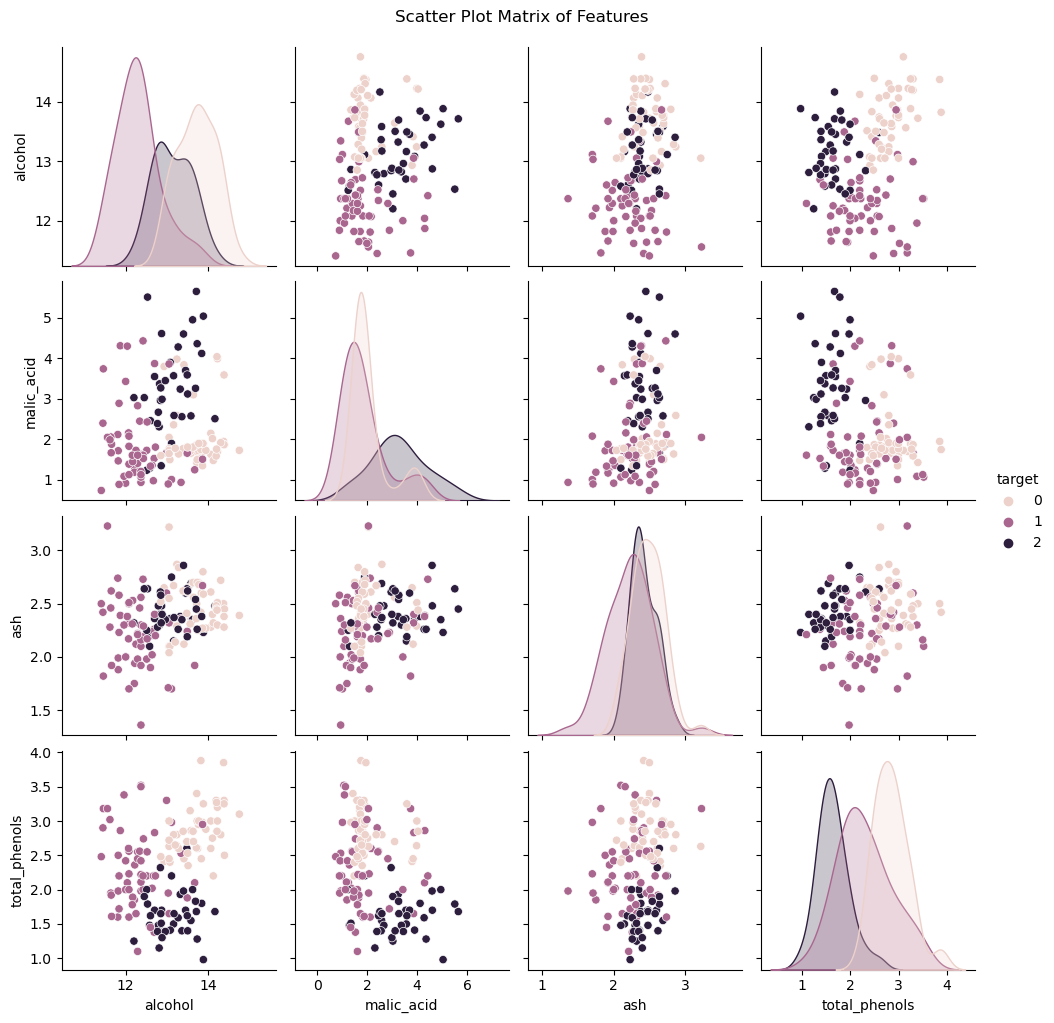

In [9]:
# Visualization 1: Scatter plot matrix of features colored by target
#A scatter plot matrix of alcohol, malic acid, ash, and total phenols, colored by the target class. This allows us to see relationships between multiple features at once
plt.figure(figsize=(12, 12))
sns.pairplot(wine_train, hue='target', vars=['alcohol', 'malic_acid', 'ash', 'total_phenols'])
plt.suptitle('Scatter Plot Matrix of Features', y=1.02)
plt.show()

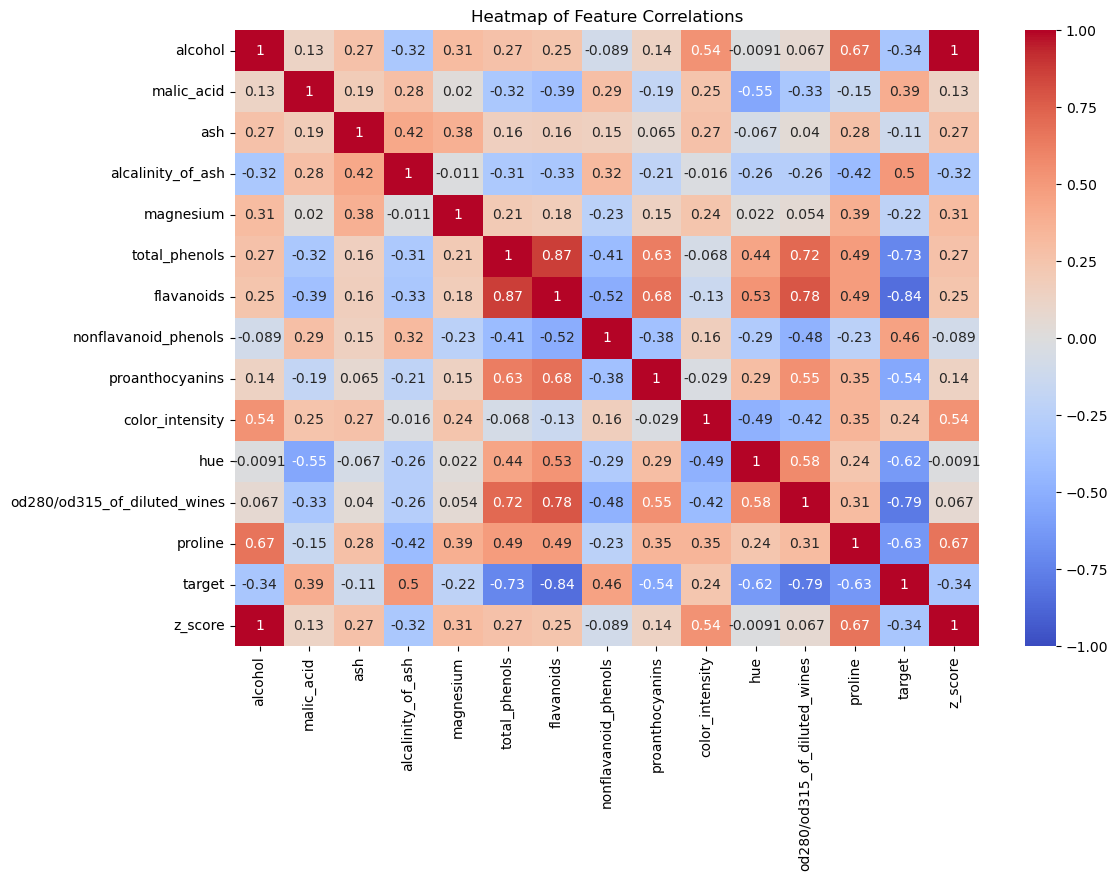

In [10]:
# Visualization - Heatmap of Corrolation between features in order to see what we can assume
plt.figure(figsize=(12, 8))
correlation_matrix = wine_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Feature Correlations')
plt.show()

# we will use the data from this heatmap in order to get the score of all correleation between the features.

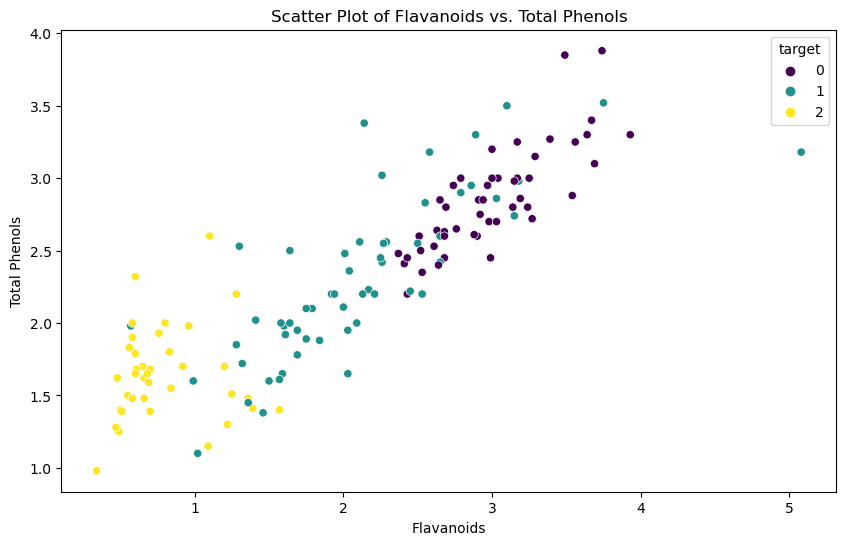

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=wine_train, x='flavanoids', y='total_phenols', hue='target', palette='viridis')
plt.title('Scatter Plot of Flavanoids vs. Total Phenols')
plt.xlabel('Flavanoids')
plt.ylabel('Total Phenols')
plt.show()

# The strong positive correlation between these two features indicates that as the flavanoid content increases,
# the total phenol content also tends to increase.
# The color-coding helps in distinguishing how this relationship varies across different wine types (target classes)

### Experiment

In [ ]:
# Separate features and labels
X_train = wine_train.drop(columns=['target', 'z_score'])  
y_train = wine_train['target']  
X_test = wine_test.drop(columns=['target'])  
y_test = wine_test['target']  

# Define feature engineering options (scale)
feature_engineering_options = {
    'none': lambda X: X,  
    'Standard': lambda X: StandardScaler().fit_transform(X),  
    'minmax': lambda X: MinMaxScaler().fit_transform(X), 
    'polynomial': lambda X: PolynomialFeatures(degree=2).fit_transform(X)  
}

# Define models and their parameters
models_params = {
    'Random Forest': { 
        'estimator': RandomForestClassifier(),  # Random Forest classifier
        'params': {  
            'n_estimators': [100, 200],  
            'max_depth': [None, 10, 20],  
            'min_samples_split': [2, 5]  }
    },
    'Knn': {  # K-Nearest Neighbors model
        'estimator': KNeighborsClassifier(),  
        'params': {  
            'n_neighbors': [3, 5, 7],  
            'weights': ['uniform', 'distance']  
        }
    },
    'Decision Tree': {  
        'estimator': DecisionTreeClassifier(),  # Decision Tree classifier
        'params': { 
            'max_depth': [None, 10, 20],  
            'min_samples_split': [2, 5]  e
        }
    },
    'Svm': {  # Support Vector Classifier model
        'estimator': SVC(),  
        'params': {  
            'C': [0.1, 1, 10],  
            'kernel': ['linear', 'rbf']  
        }
    }
}

# Use macro averaging for F1 score
scorer = make_scorer(f1_score, average='macro') 

# Training and optimization results
results = []

# Train and optimize all combinations
for fe_name, fe_func in feature_engineering_options.items():  
    for model_name, model_info in models_params.items():  
        estimator = model_info['estimator'] 
        params = model_info['params'] 

        X_train_fe = fe_func(X_train) 

        grid_search = GridSearchCV(estimator, params, cv=5, scoring=scorer) 
        grid_search.fit(X_train_fe, y_train)  
        X_test_fe = fe_func(X_test)  

        # Predict labels for the preprocessed test set (X_test_fe) using the best model found by grid_search
        y_pred = grid_search.best_estimator_.predict(X_test_fe)  
        
        # Calculate the F1 score on the test set predictions (y_pred) using macro averaging
        f1 = f1_score(y_test, y_pred, average='macro')  

        # Save the results for this combination of feature engineering method and model to the results list
        results.append({  
            'Feature': fe_name,  
            'Model': model_name,  
            'Best Params': grid_search.best_params_,  
            'Best CV': grid_search.best_score_, 
            'Test F1': f1  
        })



# Summarize results
results_df = pd.DataFrame(results)
print(results_df.to_markdown())

# Display the best combination
best_result = results_df.loc[results_df['Test F1'].idxmax()]
print(f"Best combination:\n{best_result}")

|    | Feature    | Model         | Best Params                                                      |   Best CV |   Test F1 |
|---:|:-----------|:--------------|:-----------------------------------------------------------------|----------:|----------:|
|  0 | none       | Random Forest | {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}   |  0.98632  |  1        |
|  1 | none       | Knn           | {'n_neighbors': 7, 'weights': 'uniform'}                         |  0.660951 |  0.712821 |
|  2 | none       | Decision Tree | {'max_depth': 10, 'min_samples_split': 5}                        |  0.891892 |  0.919341 |
|  3 | none       | Svm           | {'C': 0.1, 'kernel': 'linear'}                                   |  0.952445 |  0.973162 |
|  4 | Standard   | Random Forest | {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} |  0.98632  |  1        |
|  5 | Standard   | Knn           | {'n_neighbors': 7, 'weights': 'uniform'}                         |  0.96438

##  Training flow
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part 

In [ ]:
# Use the best combination

# Retrieve the best model name, best parameters, and best feature engineering method from the results
best_model_name = best_result['Model']  
best_params = best_result['Best Params'] 
best_fe_name = best_result['Feature'] 
best_fe_func = feature_engineering_options[best_fe_name]  

best_estimator = models_params[best_model_name]['estimator']
best_estimator.set_params(**best_params)
X_train_best_fe = best_fe_func(X_train)

# Train the best model on the entire training set using the transformed features
best_estimator.fit(X_train_best_fe, y_train)

# Print a confirmation message
print("Best model trained on the entire training set.")


Best model trained on the entire training set.


## Apply on test and show model performance estimation

In [14]:

 #Apply the best feature engineering method to the test set
X_test_best_fe = best_fe_func(X_test)

# Predict labels for the test set using the best model
y_pred_best = best_estimator.predict(X_test_best_fe)

# Display the first few predictions on the test set
print("First few predictions on the test set:")
for i in range(min(5, len(y_pred_best))):
    print(f"Prediction: {y_pred_best[i]}, Actual: {y_test.iloc[i]}")

# Evaluate the model performance on the test set
test_f1_best = f1_score(y_test, y_pred_best, average='macro')
print(f"\nTest F1 score of the best model on the test set: {test_f1_best:.4f}")


First few predictions on the test set:
Prediction: 2, Actual: 2
Prediction: 0, Actual: 0
Prediction: 2, Actual: 2
Prediction: 1, Actual: 1
Prediction: 2, Actual: 2

Test F1 score of the best model on the test set: 1.0000


In [15]:
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_best))

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        11

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

